In [1]:
import numpy as np
import scipy.signal as signal
from scipy.stats import skew as skewness
from scipy.stats import kurtosis as kurtosis_value
import pandas as pd

import librosa
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2


dataset_audio = pd.read_csv("dataset heartbeat.csv") 
audio_paths = []
labels = []


# Pra-pemrosesan audio dan ekstraksi fitur Hjorth
segment_length = 1000  # Panjang segmen suara (misalnya 1 detik)
overlap = 0.5  # Jumlah tumpang tindih antara segmen-suara
features = []


for i in range(len(dataset_audio)):
    file_name = "dataset/training-a/wav/" + dataset_audio['Data'][i] + ".wav"
    audio_paths.append(file_name)

    print(file_name)

    # labels.append(dataset_audio['Column2'][i])
    labels.append(dataset_audio['Label'][i])



# Pra-pemrosesan audio dan pemotongan segmen
def preprocess_audio(audio_path, segment_length, overlap):
    audio, sr = librosa.load(audio_path, sr=None)
    audio_normalized = audio / np.max(np.abs(audio))  # Normalisasi amplitudo audio

    segments = []
    step = int(segment_length * (1 - overlap))
    for i in range(0, len(audio_normalized) - segment_length, step):
        segment = audio_normalized[i:i + segment_length]
        segments.append(segment)
    return segments


# Fungsi untuk menghitung fitur-fitur Hjorth
def hjorth_features(signal):
    diff1 = np.diff(signal)
    diff2 = np.diff(signal, 2)
    var_signal = np.var(signal)
    var_diff1 = np.var(diff1)
    var_diff2 = np.var(diff2)
    mobility = np.sqrt(var_diff1 / var_signal)
    complexity = np.sqrt(var_diff2 / var_diff1) / mobility if var_diff1 != 0 else 0
    return np.mean(signal), np.std(signal), mobility, complexity, np.mean(diff1), np.std(diff1), np.mean(diff2), np.std(diff2)



for audio_path in audio_paths:
    audio, sr = librosa.load(audio_path, sr=None)
    audio_normalized = audio / np.max(np.abs(audio))  # Normalisasi amplitudo audio coarse grain
    mean, std, mobility, complexity, mean_diff1, std_diff1, mean_diff2, std_diff2 = hjorth_features(audio_normalized)
    features.append([mean, std, mobility, complexity, mean_diff1, std_diff1, mean_diff2, std_diff2])




dataset/training-a/wav/a0001.wav
dataset/training-a/wav/a0002.wav
dataset/training-a/wav/a0003.wav
dataset/training-a/wav/a0004.wav
dataset/training-a/wav/a0005.wav
dataset/training-a/wav/a0006.wav
dataset/training-a/wav/a0007.wav
dataset/training-a/wav/a0008.wav
dataset/training-a/wav/a0009.wav
dataset/training-a/wav/a0010.wav
dataset/training-a/wav/a0011.wav
dataset/training-a/wav/a0012.wav
dataset/training-a/wav/a0013.wav
dataset/training-a/wav/a0014.wav
dataset/training-a/wav/a0015.wav
dataset/training-a/wav/a0016.wav
dataset/training-a/wav/a0017.wav
dataset/training-a/wav/a0018.wav
dataset/training-a/wav/a0019.wav
dataset/training-a/wav/a0020.wav
dataset/training-a/wav/a0021.wav
dataset/training-a/wav/a0022.wav
dataset/training-a/wav/a0023.wav
dataset/training-a/wav/a0024.wav
dataset/training-a/wav/a0025.wav
dataset/training-a/wav/a0026.wav
dataset/training-a/wav/a0027.wav
dataset/training-a/wav/a0028.wav
dataset/training-a/wav/a0029.wav
dataset/training-a/wav/a0030.wav
dataset/tr

In [4]:
from sklearn.preprocessing import LabelEncoder

features = np.array(features)
labels = np.array(labels)

# Melakukan label encoding pada label kelas
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)



# # Split dataset menjadi data latih dan data uji
# X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

# # Mengubah bentuk data menjadi 3 dimensi untuk RNN-LSTM (jumlah sampel, panjang setiap sampel, jumlah fitur)
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
# X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [15]:
x_train, x_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)


# x_train = np.concatenate((normal_sounds, murmur_sounds))
# y_train = np.concatenate((normal_labels, murmur_labels))
x_train[5].shape

# Mengubah bentuk data menjadi 3 dimensi untuk RNN-LSTM (jumlah sampel, panjang setiap sampel, jumlah fitur)
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

x_train[5].shape

(1, 8)

In [16]:
print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.35, return_sequences=True, input_shape = (1, 8)))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.35, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=100)

model.summary()


Build LSTM RNN model ...
Epoch 1/100
11/11 [==============================] - 13s 9ms/step - loss: 0.6794 - accuracy: 0.7003
Epoch 2/100
11/11 [==============================] - 0s 11ms/step - loss: 0.6507 - accuracy: 0.7125
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 0.6144 - accuracy: 0.7125
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 0.5965 - accuracy: 0.7125
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5928 - accuracy: 0.7125
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 0.5845 - accuracy: 0.7125
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 0.5745 - accuracy: 0.7125
Epoch 8/100
11/11 [==============================] - 0s 11ms/step - loss: 0.5789 - accuracy: 0.7125
Epoch 9/100
11/11 [==============================] - 0s 11ms/step - loss: 0.5876 - accuracy: 0.7125
Epoch 10/100
11/11 [==============================] - 0s 12ms/step - loss: 0.

In [5]:
# Melakukan prediksi pada data uji
predictions = model.predict(x_test)

3/3 [==============================] - 1s 3ms/step


In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)


print("RMSE : ", rmse)
print("MSE : ", mse)
print("MAE : ", mae)

RMSE :  0.42414932205040995
MSE :  0.17990264739582237
MAE :  0.3689322611998494


In [7]:
y_pred = np.argmax(predictions, axis=1)

# Mengembalikan label kelas dari label encoding
# y_test = label_encoder.inverse_transform(y_test)
# y_pred = label_encoder.inverse_transform(y_pred)

# Menghitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi:", accuracy)

Akurasi: 0.7195121951219512


# VALIDATION

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_score, recall_score 
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import KFold


In [9]:
# CONFUSION MATRIX

# Memprediksi label pada data uji
Y_pred_prob = model.predict(x_test)
Y_pred = np.argmax(Y_pred_prob, axis=1)


y_test_encoded = label_encoder.fit_transform(y_test)
y_pred_encoded = label_encoder.transform(y_pred)

# Menghitung confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_encoded)

# Menampilkan confusion matrix
print("Confusion Matrix:")
print(cm)

3/3 [==============================] - 0s 3ms/step
Confusion Matrix:
[[59  0]
 [23  0]]


In [10]:
# Menginisialisasi confusion matrix
cm_total = np.zeros((len(label_encoder.classes_), len(label_encoder.classes_)))

# Mengonversi label menjadi tipe numerik
y_encoded = label_encoder.fit_transform(labels_encoded)

# Melakukan K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1


for train_index, test_index in kfold.split(features):
    X_train, X_test = features[train_index], features[test_index]
    Y_trains, Y_tests = y_encoded[train_index], y_encoded[test_index]

    x_train_reshaped = np.expand_dims(X_train,axis=1)
    x_test_reshaped = np.expand_dims(X_test, axis=1)

    # Membangun dan melatih model di setiap fold
    model = Sequential()
    model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.35, return_sequences=True, input_shape = (1, 8)))
    model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.35, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(x_train_reshaped, Y_trains, batch_size=32, epochs=100)

    # Memprediksi label pada data uji
    Y_pred = model.predict(x_test_reshaped)
    Y_pred_classes = np.argmax(Y_pred, axis=1)

    # Menghitung dan menampilkan confusion matrix pada setiap fold
    rmse = np.sqrt(mean_squared_error(y_test, Y_pred))
    mse = mean_squared_error(y_test, Y_pred)
    mae = mean_absolute_error(y_test, Y_pred)


    print("RMSE : ", rmse)
    print("MSE : ", mse)
    print("MAE : ", mae)



Epoch 1/100
11/11 [==============================] - 7s 7ms/step - loss: 0.6835 - accuracy: 0.6361
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6504 - accuracy: 0.7125
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6234 - accuracy: 0.7125
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5930 - accuracy: 0.7125
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 0.5888 - accuracy: 0.7125
Epoch 6/100
11/11 [==============================] - 0s 6ms/step - loss: 0.5793 - accuracy: 0.7125
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5824 - accuracy: 0.7125
Epoch 8/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5809 - accuracy: 0.7125
Epoch 9/100
11/11 [==============================] - 0s 6ms/step - loss: 0.5798 - accuracy: 0.7125
Epoch 10/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5788 - accuracy: 0.7125
Epoch 11/

ValueError: Found input variables with inconsistent numbers of samples: [82, 81]

Confusion Matrix - Total:
[[292.   0.]
 [117.   0.]]


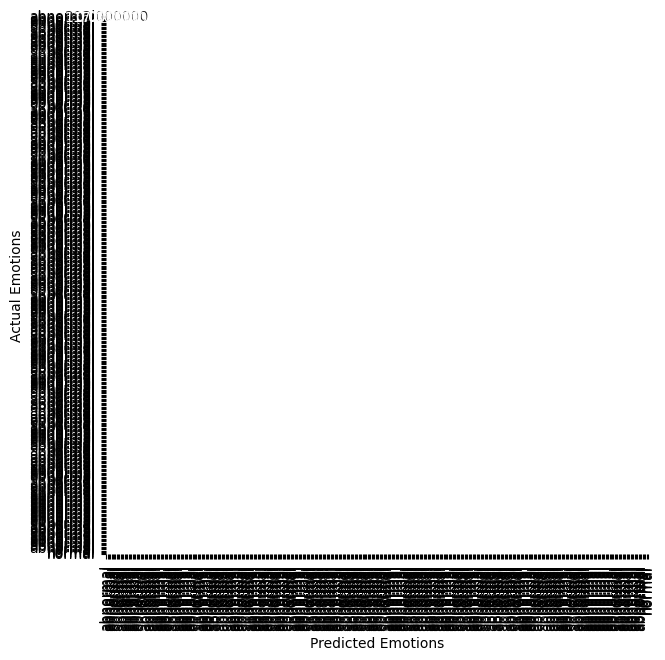

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Menampilkan confusion matrix total
print("Confusion Matrix - Total:")
print(cm_total)
